# **Clasificación utilizando LightGBM (LGBM)**

El dataset de predicción de préstamos contiene información sobre solicitantes de préstamos, como sus ingresos, historial crediticio y otras características personales. El objetivo es predecir si un solicitante será aprobado para un préstamo basándose en estos factores.

LightGBM, libreria para regresion y clasificacion. Muy Flexible y permite el ajuste de varios parametros para otimizar el rendimiento del modelo.

# **Parte 1: Carga y Exploración Inicial de Datos**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/BBDD/train.csv"
import pandas as pd
df = pd.read_csv(path)

Mounted at /content/drive


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


identificacion de valores faltantes.

In [5]:
# Porcentaje de valores faltantes
missing_percent = df.isnull().mean() * 100
missing = missing_percent[missing_percent > 0]
print("Valores faltantes por columna:\n", missing.sort_values(ascending=False))

Valores faltantes por columna:
 Credit_History      8.143322
Self_Employed       5.211726
LoanAmount          3.583062
Dependents          2.442997
Loan_Amount_Term    2.280130
Gender              2.117264
Married             0.488599
dtype: float64


estadisticas descriptivas

         Loan_ID Gender Married Dependents Education Self_Employed  \
count        614    601     611        599       614           582   
unique       614      2       2          4         2             2   
top     LP002990   Male     Yes          0  Graduate            No   
freq           1    489     398        345       480           500   
mean         NaN    NaN     NaN        NaN       NaN           NaN   
std          NaN    NaN     NaN        NaN       NaN           NaN   
min          NaN    NaN     NaN        NaN       NaN           NaN   
25%          NaN    NaN     NaN        NaN       NaN           NaN   
50%          NaN    NaN     NaN        NaN       NaN           NaN   
75%          NaN    NaN     NaN        NaN       NaN           NaN   
max          NaN    NaN     NaN        NaN       NaN           NaN   

        ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count        614.000000         614.000000  592.000000         600.00000   
unique 

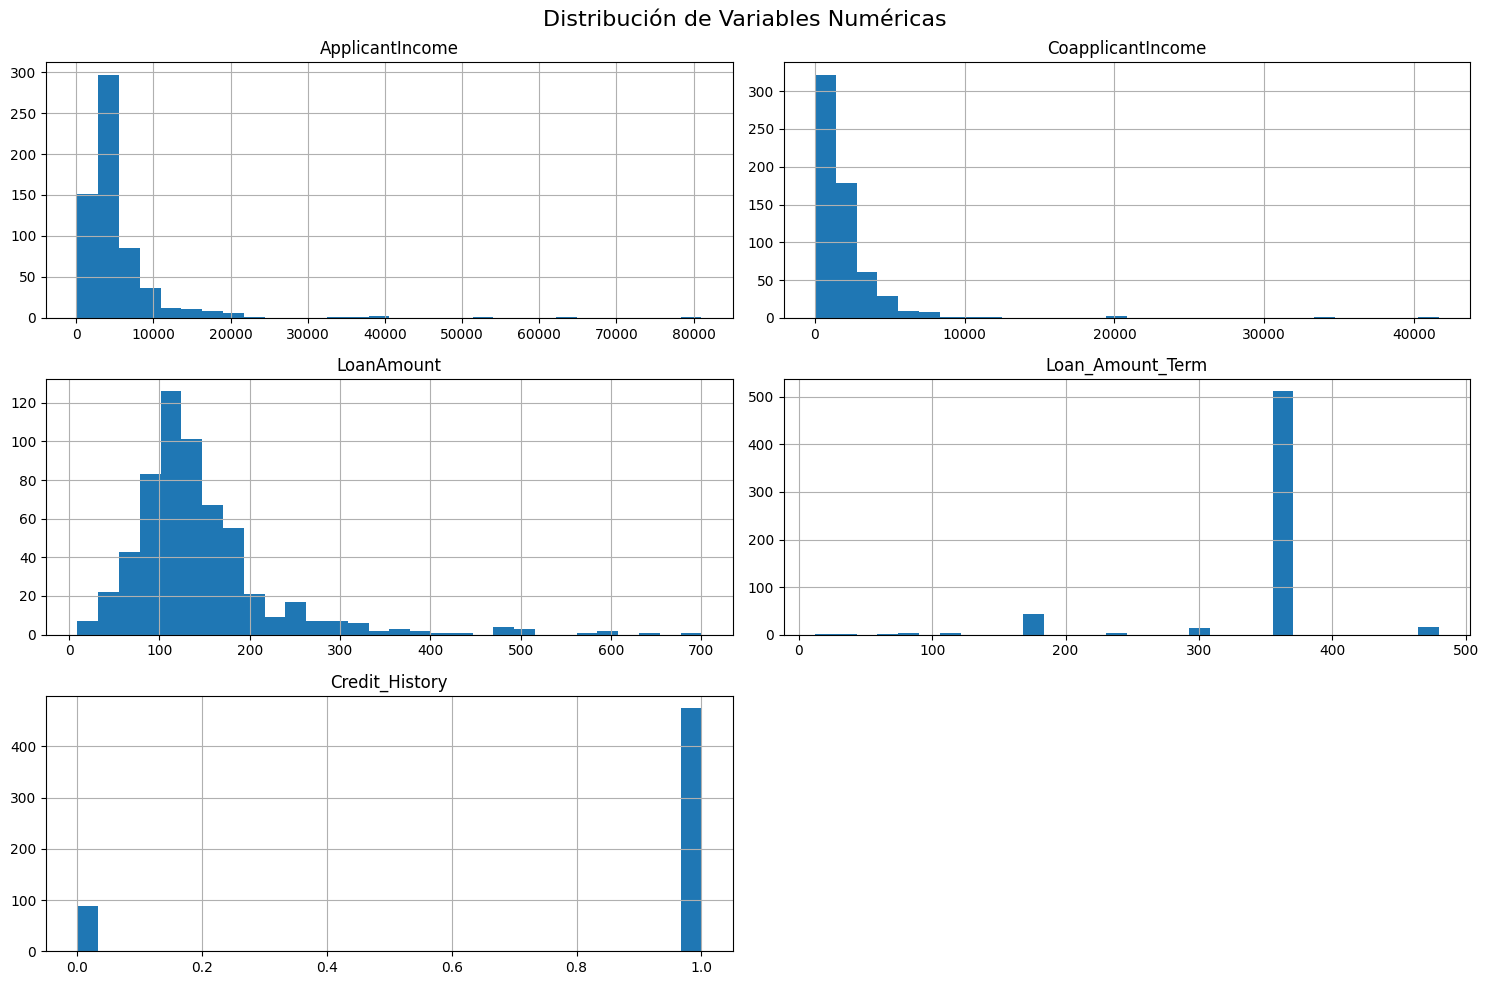

In [6]:
# Estadísticas descriptivas
print(df.describe(include='all'))  # Incluye tanto numéricas como categóricas

# Distribución de variables numéricas
import matplotlib.pyplot as plt
import seaborn as sns

df.hist(figsize=(15, 10), bins=30)
plt.suptitle("Distribución de Variables Numéricas", fontsize=16)
plt.tight_layout()
plt.show()

Outliers con boxplot

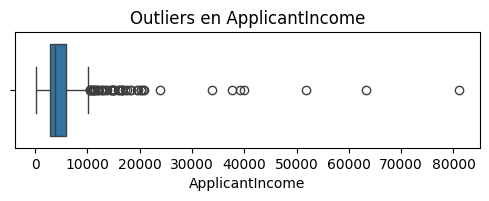

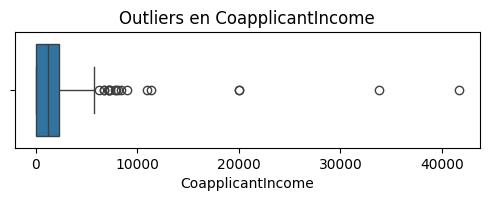

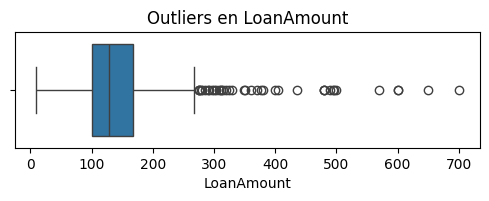

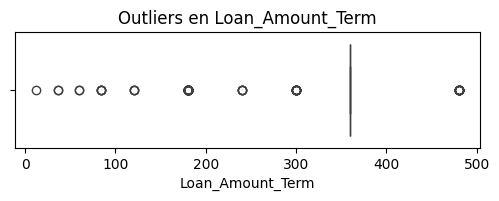

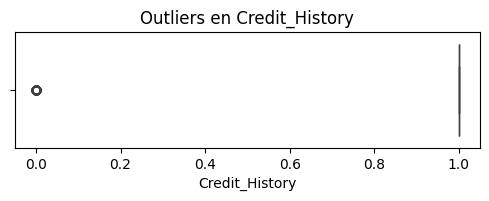

In [7]:
# Boxplots para detectar outliers en variables numéricas
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f"Outliers en {col}")
    plt.show()

Mapa de calor de correlaciones entre variables numéricas

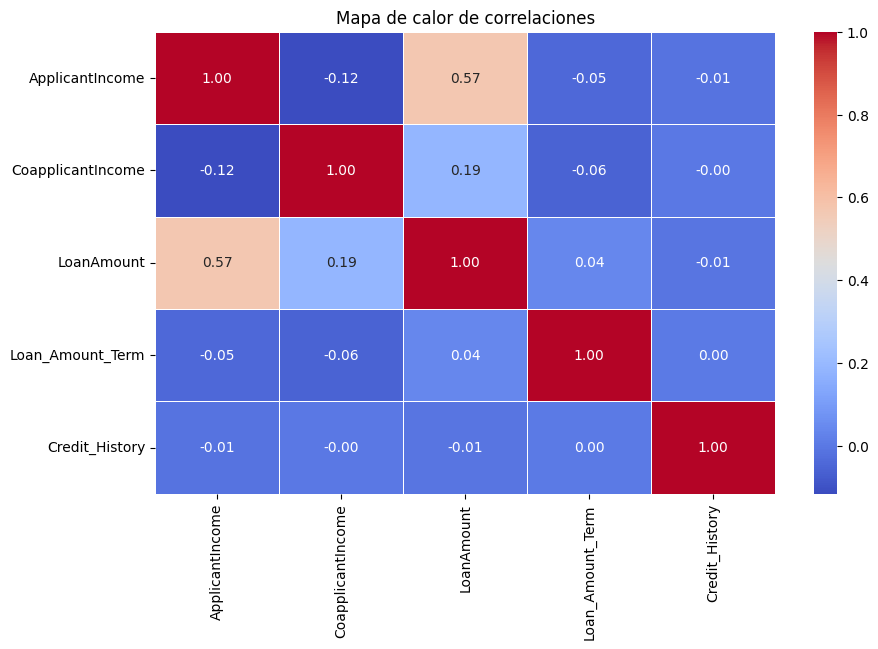

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionamos solo las columnas numéricas
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Calculamos la matriz de correlación
correlation_matrix = df_numeric.corr()

# Graficamos el mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de calor de correlaciones')
plt.show()

* Hay una correlación moderada (0.57) entre ApplicantIncome y LoanAmount, lo que sugiere que a mayor ingreso del solicitante, mayor puede ser el monto del préstamo.

* El resto de las correlaciones son bajas o casi nulas, indicando relaciones débiles entre esas variables.

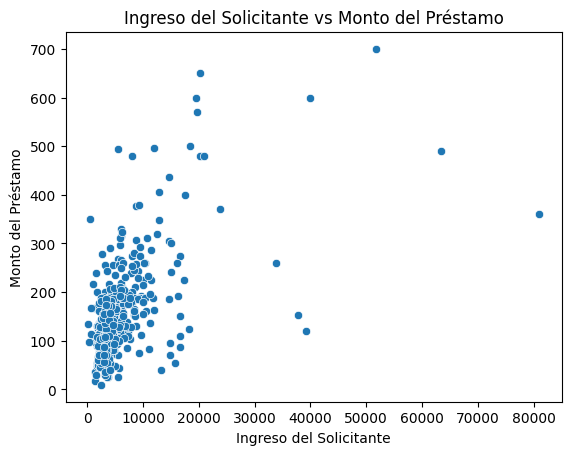

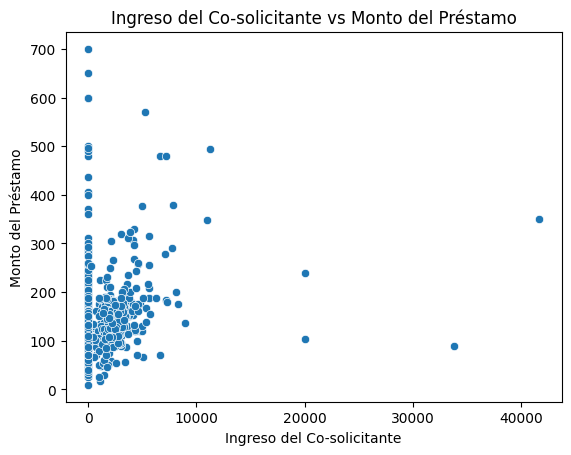

In [9]:
# Gráfico de dispersión: Ingreso vs Monto del Préstamo
sns.scatterplot(data=df, x='ApplicantIncome', y='LoanAmount')
plt.title('Ingreso del Solicitante vs Monto del Préstamo')
plt.xlabel('Ingreso del Solicitante')
plt.ylabel('Monto del Préstamo')
plt.show()

# Otro ejemplo: CoapplicantIncome vs LoanAmount
sns.scatterplot(data=df, x='CoapplicantIncome', y='LoanAmount')
plt.title('Ingreso del Co-solicitante vs Monto del Préstamo')
plt.xlabel('Ingreso del Co-solicitante')
plt.ylabel('Monto del Préstamo')
plt.show()

**Ingreso del Solicitante vs Monto del Préstamo**

1.   Se observa una relación positiva moderada: a mayor ingreso, tiende a solicitarse un monto mayor de préstamo.
2.   Sin embargo, hay outliers con ingresos muy altos y préstamos relativamente bajos, lo cual puede distorsionar el análisis.

**Ingreso del Co-solicitante vs Monto del Préstamo**
3. La relación es más débil que en el primer gráfico.
4. Se concentra gran parte de los datos cuando el ingreso del co-solicitante es cero (es decir, no hay co-solicitante).

# **Parte 2: Deteccion de outliers y manejo de valore faltantes.**

---




In [10]:
# Porcentaje de valores faltantes por columna
missing_percent = df.isnull().mean() * 100
missing = missing_percent[missing_percent > 0].sort_values(ascending=False)

print("Valores faltantes (%):")
print(missing)

Valores faltantes (%):
Credit_History      8.143322
Self_Employed       5.211726
LoanAmount          3.583062
Dependents          2.442997
Loan_Amount_Term    2.280130
Gender              2.117264
Married             0.488599
dtype: float64


In [12]:
# Crear una copia para no modificar el original
df_cleaned = df.copy()

# =============================
# 1. IMPUTACIÓN DE VALORES FALTANTES
# =============================

# CATEGÓRICAS: rellenar con la moda (valor más frecuente)
categorical_columns = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']
for col in categorical_columns:
    moda = df_cleaned[col].mode()[0]
    df_cleaned[col] = df_cleaned[col].fillna(moda)

# NUMÉRICAS: rellenar con la mediana (menos sensible a outliers)
numerical_columns = ['LoanAmount', 'Loan_Amount_Term']
for col in numerical_columns:
    mediana = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(mediana)


# =============================
# 2. MANEJO DE OUTLIERS CON MÉTODO IQR
# =============================

# Función que elimina outliers según IQR
def filter_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]

# Aplicar la función a columnas numéricas propensas a outliers
outlier_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
for col in outlier_columns:
    df_cleaned = filter_outliers_iqr(df_cleaned, col)

# =============================
# 3. RESULTADO
# =============================

# Verifica si el dataframe final está limpio
print(df_cleaned.info())
print(df_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
Index: 520 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            520 non-null    object 
 1   Gender             520 non-null    object 
 2   Married            520 non-null    object 
 3   Dependents         520 non-null    object 
 4   Education          520 non-null    object 
 5   Self_Employed      520 non-null    object 
 6   ApplicantIncome    520 non-null    int64  
 7   CoapplicantIncome  520 non-null    float64
 8   LoanAmount         520 non-null    float64
 9   Loan_Amount_Term   520 non-null    float64
 10  Credit_History     520 non-null    float64
 11  Property_Area      520 non-null    object 
 12  Loan_Status        520 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 56.9+ KB
None
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      

# **Parte 3: Pre-Procesamiento de los datos**

---



In [21]:
# One-Hot Encoding (excluyendo la variable objetivo 'Loan_Status')
df_encoded = pd.get_dummies(df_cleaned, columns=[
    'Gender', 'Married', 'Dependents', 'Education',
    'Self_Employed', 'Property_Area'
], drop_first=True)

In [22]:
from sklearn.preprocessing import StandardScaler

# Instanciar el escalador
scaler = StandardScaler()

# Seleccionar columnas numéricas a escalar
numeric_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# Escalar y reemplazar en el DataFrame
df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])

**Division del conjunto de datos.**

In [23]:
from sklearn.model_selection import train_test_split

# Variable objetivo: codificar Y como 1 (aprobado) y 0 (no aprobado)
df_encoded['Loan_Status'] = df_encoded['Loan_Status'].map({'Y': 1, 'N': 0})

# Separar variables predictoras y objetivo
X = df_encoded.drop(columns='Loan_Status')
y = df_encoded['Loan_Status']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# **Parte 4: Implementación de LightGBM (LGBM)**

---


In [24]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
X_train = X_train.drop(columns='Loan_ID', errors='ignore')
X_test = X_test.drop(columns='Loan_ID', errors='ignore')
# Entrenar modelo base
lgbm_base = lgb.LGBMClassifier(random_state=42)
lgbm_base.fit(X_train, y_train)

# Predicciones
y_pred = lgbm_base.predict(X_test)
y_proba = lgbm_base.predict_proba(X_test)[:, 1]

# Evaluación de métricas
print("🔹 Evaluación Modelo Base")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 290, number of negative: 126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 416, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.697115 -> initscore=0.833599
[LightGBM] [Info] Start training from score 0.833599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

optimizacion de hiperparametros

In [25]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Definimos una nueva instancia del modelo para no sobreescribir el modelo base
lgbm_grid = lgb.LGBMClassifier(random_state=42)

# Grilla de hiperparámetros para buscar
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63]
}

# Configurar búsqueda con validación cruzada
grid_search = GridSearchCV(
    estimator=lgbm_grid,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Entrenar búsqueda
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado
best_lgbm = grid_search.best_estimator_

# Predicciones del modelo optimizado
y_pred_opt = best_lgbm.predict(X_test)
y_proba_opt = best_lgbm.predict_proba(X_test)[:, 1]

# Evaluación del modelo optimizado
print("🔹 Evaluación Modelo Optimizado")
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_opt))
print("Precision:", precision_score(y_test, y_pred_opt))
print("Recall:", recall_score(y_test, y_pred_opt))
print("F1 Score:", f1_score(y_test, y_pred_opt))
print("ROC AUC:", roc_auc_score(y_test, y_proba_opt))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 290, number of negative: 126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 416, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.697115 -> initscore=0.833599
[LightGBM] [Info] Start training from score 0.833599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

**Comparación de modelo base y optimizado.**

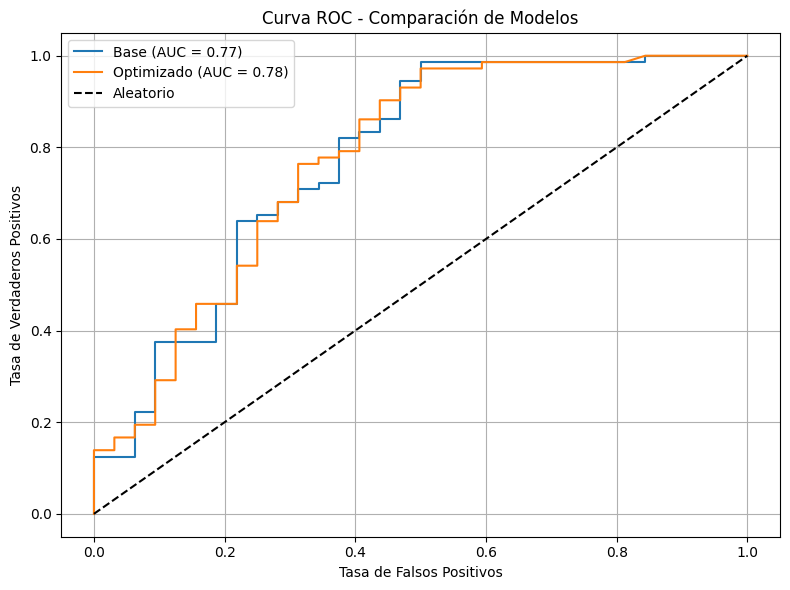

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Si no las tienes, crea nuevamente:
y_pred_base = lgbm_base.predict(X_test)
y_proba_base = lgbm_base.predict_proba(X_test)[:, 1]

y_pred_opt = best_lgbm.predict(X_test)
y_proba_opt = best_lgbm.predict_proba(X_test)[:, 1]

# 1. Guardar métricas en diccionarios
metrics_base = {
    "Accuracy": accuracy_score(y_test, y_pred_base),
    "Precision": precision_score(y_test, y_pred_base),
    "Recall": recall_score(y_test, y_pred_base),
    "F1 Score": f1_score(y_test, y_pred_base),
    "ROC AUC": roc_auc_score(y_test, y_proba_base)
}

metrics_opt = {
    "Accuracy": accuracy_score(y_test, y_pred_opt),
    "Precision": precision_score(y_test, y_pred_opt),
    "Recall": recall_score(y_test, y_pred_opt),
    "F1 Score": f1_score(y_test, y_pred_opt),
    "ROC AUC": roc_auc_score(y_test, y_proba_opt)
}

# 3. Curva ROC
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_base)
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_proba_opt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f'Base (AUC = {metrics_base["ROC AUC"]:.2f})')
plt.plot(fpr_opt, tpr_opt, label=f'Optimizado (AUC = {metrics_opt["ROC AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Comparación de Modelos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()